In [ ]:
# Use VGG16 (headless and pre-trained on Image) to recognize data from Fruits dataset
# On the top of prepared network we stack Dense layer with outputs corresponding to dataset classes

from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from glob import glob

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-07-27 16:52:39.168928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:52:39.349076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:52:39.350153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Constants

In [ ]:
input_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360'
train_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
valid_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'
folders = glob(train_path + '/*')
os.listdir(input_path)

['papers', 'LICENSE', 'Training', 'readme.md', 'test-multiple_fruits', 'Test']

In [ ]:
IMAGE_SIZE = [100, 100]
epochs = 5
batch_size = 32

## VGG16 preparation

In [ ]:
# prepare VGG16
vgg = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

# freeze layers trainability
for layer in vgg.layers:
    layer.trainable = False

# add top layer(s)
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

2022-07-27 16:53:30.520043: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 16:53:30.520499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:53:30.521655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 16:53:30.522537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
model.compile(
             loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy']
             )

## Data preparation, ImageDataGenerator

In [ ]:
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)

labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v]=k

print(labels)

Found 22688 images belonging to 131 classes.
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango'

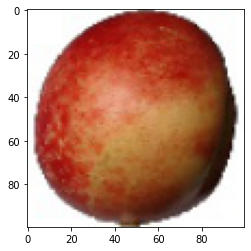

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

min:  -114.46964 max:  151.061


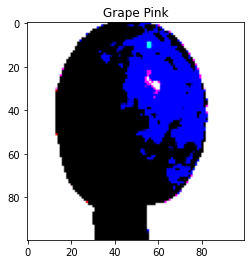

In [ ]:
for x, y in test_gen:
    print("min: ", x[0].min(), "max: ", x[0].max())  # strange colors bc BGR instead of RGB
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Actual fitting and resulting

In [ ]:
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-07-27 16:59:50.758334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-07-27 16:59:52.657399: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2115/2115 [==============================] - 701s 327ms/step - loss: 1.6586 - accuracy: 0.8846 - val_loss: 1.6007 - val_accuracy: 0.9134
Epoch 2/5
2115/2115 [==============================] - 342s 162ms/step - loss: 0.3134 - accuracy: 0.9727 - val_loss: 1.4282 - val_accuracy: 0.9304
Epoch 3/5
2115/2115 [==============================] - 340s 161ms/step - loss: 0.1988 - accuracy: 0.9825 - val_loss: 1.0539 - val_accuracy: 0.9460
Epoch 4/5
2115/2115 [==============================] - 349s 165ms/step - loss: 0.1606 - accuracy: 0.9870 - val_loss: 1.1904 - val_accuracy: 0.9467
Epoch 5/5
2115/2115 [==============================] - 357s 169ms/step - loss: 0.1310 - accuracy: 0.9891 - val_loss: 1.1053 - val_accuracy: 0.9506


In [ ]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    
    for x,y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size*2):
        i += 1
        if i%50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    
    cm = confusion_matrix(targets, predictions)
    return cm

cm = get_confusion_matrix(train_path, len(image_files))
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))

Generating confusion matrix 67692
Found 67692 images belonging to 131 classes.
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
Generating confusion matrix 22688
Found 22688 images belonging to 131 classes.
50
100
150
200
250
300
350


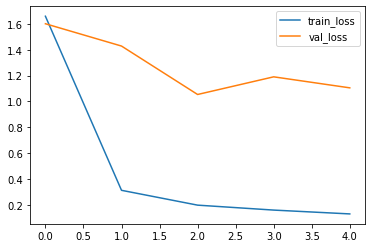

In [ ]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

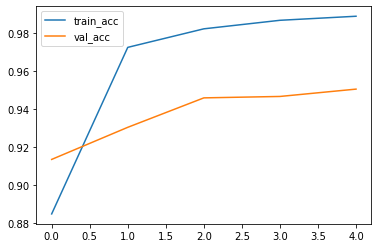

In [ ]:
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

[[[402], [0], [0], [0], [0], [0], [0], [22], [4], [0], [0], [0], [0]], [[1], [436], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0]], [[0], [0], [480], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [484], [3], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [2], [6], [449], [14], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [488], [0], [0], [0], [0], [0], [0], [0]], [[0], [22], [0], [0], [0], [0], [396], [4], [2], [1], [0], [17], [0]], [[0], [0], [0], [0], [0], [0], [0], [491], [0], [1], [0], [0], [0]], [[1], [0], [0], [0], [0], [0], [4], [3], [480], [0], [0], [1], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [429], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [488], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [491], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [666]]]


<AxesSubplot:title={'center':'VGG16 classifying apple types'}>

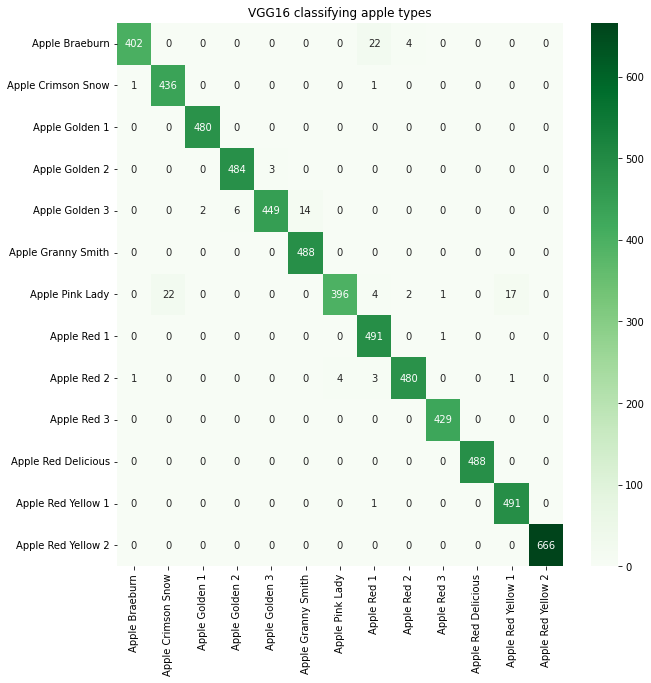

In [ ]:
# check how well it recognizes different apple types
apples_classes_dict = {}
i=0
for label in labels:
    if 'Apple' in label:
        apples_classes_dict[label]=i
    i += 1

apples_cm = []
for i in apples_classes_dict.values():
    row = []
    for j in apples_classes_dict.values():
        row.append([cm[i][j]])
    apples_cm.append(row)
print(apples_cm)

apples_cm = np.array(apples_cm).reshape(len(apples_classes_dict.values()), -1)

plt.figure(figsize=(10,10))
plt.title("VGG16 classifying apple types")
sns.heatmap(apples_cm,annot=True,fmt="g",cmap='Greens', 
            xticklabels=apples_classes_dict.keys(), 
            yticklabels=apples_classes_dict.keys())